# Disparity Mitigation Example

In [1]:
import pandas as pd
from sklearn import metrics
import solas_disparity as sd
import xgboost as xgb

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', 1000)

## Import and Prepare the Data

In [2]:
try:
    df = pd.read_parquet("C:/Users/nickp/repos/solas-ai-disparity/examples/data/20221221_simulated_credit_data_w_preds.parquet.gz")
except:
    df = pd.read_parquet("https://github.com/SolasAI/solas-ai-disparity/blob/main/examples/data/20221221_simulated_credit_data_w_preds.parquet.gz?raw=true")

df['Default'] = 1 - df['Approved']
df = (df
      .drop(columns=['Approved', 'Baseline Prediction', 'Baseline Offer', 'Minority', 'Majority'])
      .rename(columns={'Minority-1-Proportional': 'Black', 'Minority-2-Proportional': 'Hispanic', 'Majority-Proportional': 'White'})
      .sort_index(level=['Train', 'ID'])
      .reset_index(drop=False)
)
df.sample(random_state=161803, n=5)

,Train,ID,Sample Weight,Mortgage,Balance,Amount Past Due,Delinquency Status,Credit Inquiry,Open Trade,Utilization,Gender,Race,Age,Female,Male,Age >= 62,Age < 62,Black,Hispanic,White,Default
83419,valid,17149,5.763312,343699.96,3843.43,3491.35,1.0,1.0,1.0,0.743297,Male,Majority,Age >= 62,0.0,1.0,1.0,0.0,0.011932,0.007068,0.981,1
25011,train,21419,12.409537,170872.69,931.11,0.00,0.0,1.0,1.0,0.183434,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.528570,0.310430,0.161,0
79016,train,98564,7.360731,163041.61,895.05,0.00,0.0,0.0,0.0,0.567924,Male,Minority,Age >= 62,0.0,1.0,1.0,0.0,0.393291,0.407709,0.199,0
22197,train,17432,13.661012,136040.57,80.75,52.02,2.0,0.0,0.0,0.219620,Female,Minority,Age >= 62,1.0,0.0,1.0,0.0,0.599090,0.262910,0.138,1
48321,train,54792,16.327007,247120.04,531.62,0.00,0.0,0.0,0.0,0.278665,Female,Majority,Age >= 62,1.0,0.0,1.0,0.0,0.073884,0.057116,0.869,0


In [3]:
baseline_features = ['Mortgage', 'Balance', 'Amount Past Due', 'Delinquency Status', 
            'Credit Inquiry', 'Open Trade', 'Utilization']
label = 'Default'

In [4]:
train = df.loc[df['Train'] == 'train']
valid = df.loc[df['Train'] == 'valid']

print(train.shape, valid.shape)

(70000, 21) (20000, 21)


## Train the Baseline Model

In [5]:
d_train_baseline = xgb.DMatrix(data=train[baseline_features], label=train[label])
d_valid_baseline = xgb.DMatrix(data=valid[baseline_features], label=valid[label])

# Create the evals list for early stopping.
evals = [(d_train_baseline, 'train'), (d_valid_baseline, 'valid')]

# Set the hyperparameters.
params = {
    'seed': 2718,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    'tree_method': 'gpu_hist',
    'learning_rate': 0.1,
    'max_depth': 2,
    'verbosity': 1,
}

# Train the model. Note a high number of boost rounds, but early stopping is also set.
model_baseline = xgb.train(
    dtrain=d_train_baseline, 
    params=params, 
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=100,
)
baseline_prediction_train = pd.Series(data=model_baseline.predict(d_valid_baseline), index=valid.index)
baseline_prediction_valid = pd.Series(data=model_baseline.predict(d_valid_baseline), index=valid.index)

[0]	train-logloss:0.67975	valid-logloss:0.68012
[100]	train-logloss:0.59391	valid-logloss:0.59899
[200]	train-logloss:0.59069	valid-logloss:0.59677
[300]	train-logloss:0.58937	valid-logloss:0.59616
[333]	train-logloss:0.58902	valid-logloss:0.59608


## Test the Baseline Model for Disparate Impact

In [6]:
common_info = dict(
    protected_groups=["Black",          "Hispanic",       "Female", "Age >= 62"],
    reference_groups=["White",          "White",          "Male",   "Age < 62"],
    group_categories=["Race/Ethnicity", "Race/Ethnicity", "Sex",     "Age"],
    group_data=valid,
    air_threshold=0.8,
    percent_difference_threshold=0,
)

### By-Quantile Adverse Impact Ratio

In [8]:
baseline_quantile_air = sd.adverse_impact_ratio_by_quantile(
    **common_info,
    outcome=baseline_prediction_valid,
    quantiles=[x / 100 for x in range(10, 101, 10)]
)
baseline_quantile_air.plot()
baseline_quantile_air.plot(group='Female')

### Offer-Based Adverse Impact Ratio

In [9]:
baseline_score_cutoff = baseline_prediction_train.quantile(0.3)
baseline_offer_valid = baseline_prediction_valid <= baseline_score_cutoff


baseline_offer_air = sd.adverse_impact_ratio(
    **common_info,
    outcome=baseline_offer_valid,
)
baseline_offer_air.plot()

In [10]:
sd.ui.show(baseline_offer_air.summary_table)

Group,Reference Group,Group Category,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Black,White,Race/Ethnicity,"17,951",10.25%,"3,695.9",636.1,17.21%,19.90%,0.464,0.000,Yes,735.4
Hispanic,White,Race/Ethnicity,"17,951",10.25%,"2,732.0",464.8,17.01%,20.10%,0.458,0.000,Yes,549.1
White,,Race/Ethnicity,"17,951",10.25%,"11,523.1","4,276.1",37.11%,,,,,
Female,Male,Sex,"20,000",0.00%,"10,145.0","2,207.0",21.75%,16.73%,0.565,0.000,Yes,"1,697.6"
Male,,Sex,"20,000",0.00%,"9,855.0","3,793.0",38.49%,,,,,
Age >= 62,Age < 62,Age,"19,046",4.77%,"9,429.0","2,907.0",30.83%,-1.60%,1.055,0.017,No,
Age < 62,,Age,"19,046",4.77%,"9,617.0","2,811.0",29.23%,,,,,


## Explore Drivers of Discrimination

In [11]:
valid.groupby(by='Female')[baseline_features].mean().T.rename(columns={0: 'Male', 1: 'Female'}).style.format("{:.2f}")

Female,Male,Female
Mortgage,251282.04,250069.51
Balance,1760.36,651.44
Amount Past Due,377.06,140.70
Delinquency Status,1.14,1.14
Credit Inquiry,0.39,0.39
Open Trade,0.20,0.19
Utilization,0.47,0.48


## Build the Alternative Model

In [12]:
alternative_features = [x for x in baseline_features if x not in ['Balance']]

In [13]:
d_train_alt = xgb.DMatrix(data=train[alternative_features], label=train[label])
d_valid_alt = xgb.DMatrix(data=valid[alternative_features], label=valid[label])

# Create the evals list for early stopping.
evals = [(d_train_alt, 'train'), (d_valid_alt, 'valid')]

# Set the hyperparameters.
params = {
    'seed': 2718,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    'tree_method': 'gpu_hist',
    'learning_rate': 0.1,
    'max_depth': 2,
    'verbosity': 1,
}

# Train the model. Note a high number of boost rounds, but early stopping is also set.
alt_model = xgb.train(
    dtrain=d_train_alt, 
    params=params, 
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=100,
)
alternative_prediction_train = pd.Series(data=alt_model.predict(d_valid_alt), index=valid.index)
alternative_prediction_valid = pd.Series(data=alt_model.predict(d_valid_alt), index=valid.index)

[0]	train-logloss:0.67975	valid-logloss:0.68012
[100]	train-logloss:0.59776	valid-logloss:0.60272
[200]	train-logloss:0.59561	valid-logloss:0.60144
[205]	train-logloss:0.59554	valid-logloss:0.60144


## Test the Alternative Model for Disparate Impact

In [14]:
alternative_score_cutoff = alternative_prediction_train.quantile(0.3)
alternative_offer_valid = alternative_prediction_valid <= alternative_score_cutoff

alternative_offer_air = sd.adverse_impact_ratio(
    **common_info,
    outcome=alternative_offer_valid,
)
alternative_offer_air.plot()

In [15]:
baseline_offer_air.summary_table

,Reference Group,Group Category,Observations,Percent Missing,Total,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Group,,,,,,,,,,,,
Black,White,Race/Ethnicity,17951,0.10245,3695.88431,636.121452,0.172116,0.198974,0.463812,4.888702e-112,Yes,735.384286
Hispanic,White,Race/Ethnicity,17951,0.10245,2731.97869,464.757548,0.170118,0.200972,0.458427,3.437129e-89,Yes,549.052446
White,,Race/Ethnicity,17951,0.10245,11523.13700,4276.121000,0.371090,NaN,NaN,NaN,,NaN
Female,Male,Sex,20000,0.00000,10145.00000,2207.000000,0.217546,0.167335,0.565229,8.369995e-147,Yes,1697.615424
Male,,Sex,20000,0.00000,9855.00000,3793.000000,0.384881,NaN,NaN,NaN,,NaN
Age >= 62,Age < 62,Age,19046,0.04770,9429.00000,2907.000000,0.308304,-0.016009,1.054771,1.665595e-02,No,NaN
Age < 62,,Age,19046,0.04770,9617.00000,2811.000000,0.292295,NaN,NaN,NaN,,NaN


In [16]:
air_compare = pd.merge(
    left=baseline_offer_air.summary_table[['AIR']].rename(columns={'AIR': 'Baseline AIR'}),
    right=alternative_offer_air.summary_table[['AIR']].rename(columns={'AIR': 'Alternative AIR'}),
    left_index=True, right_index=True,
)
air_compare['Percent Change in AIR'] = air_compare['Alternative AIR'] / air_compare['Baseline AIR'] - 1
formatter = {'Alternative AIR': '{:.2f}', 'Baseline AIR': '{:.2f}', 'Percent Change in AIR': '{:.2%}'}
air_compare.loc[air_compare['Baseline AIR'].notna()].style.format(formatter=formatter)
        

,Baseline AIR,Alternative AIR,Percent Change in AIR
Group,,,
Black,0.46,0.40,-14.31%
Hispanic,0.46,0.39,-15.08%
Female,0.57,0.94,67.12%
Age >= 62,1.05,1.06,0.70%


## Evaluate the Alternative Model's Model Quality

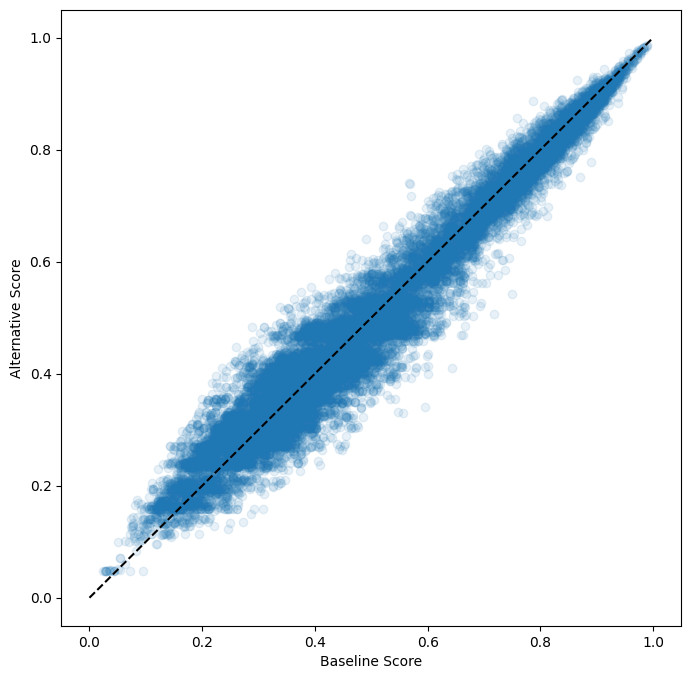

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.scatter(x=baseline_prediction_valid, y=alternative_prediction_valid, alpha=0.1)
plt.xlabel('Baseline Score')
plt.ylabel('Alternative Score')
plt.show()

In [19]:
baseline_male_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] == 0, label], y_score=baseline_prediction_valid.loc[valid['Female'] == 0])
baseline_female_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] == 1, label], y_score=baseline_prediction_valid.loc[valid['Female'] == 1])
baseline_all_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] <= 1, label], y_score=baseline_prediction_valid.loc[valid['Female'] <= 1])

alternative_male_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] == 0, label], y_score=alternative_prediction_valid.loc[valid['Female'] == 0])
alternative_female_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] == 1, label], y_score=alternative_prediction_valid.loc[valid['Female'] == 1])
alternative_all_auc = metrics.roc_auc_score(y_true=valid.loc[valid['Female'] <= 1, label], y_score=alternative_prediction_valid.loc[valid['Female'] <= 1])

print(f"Baseline AUC:    All Obs: {baseline_all_auc:0.3}, Male: {alternative_male_auc:0.3}, Female: {alternative_female_auc:0.3}")
print(f"Alternative AUC: All Obs: {alternative_all_auc:0.3}, Male: {alternative_male_auc:0.3}, Female: {alternative_female_auc:0.3}")
print(f"AUC Percent Change: {alternative_all_auc  / baseline_all_auc - 1:0.2%}")

Baseline AUC:    All Obs: 0.742, Male: 0.731, Female: 0.737
Alternative AUC: All Obs: 0.734, Male: 0.731, Female: 0.737
AUC Percent Change: -0.99%


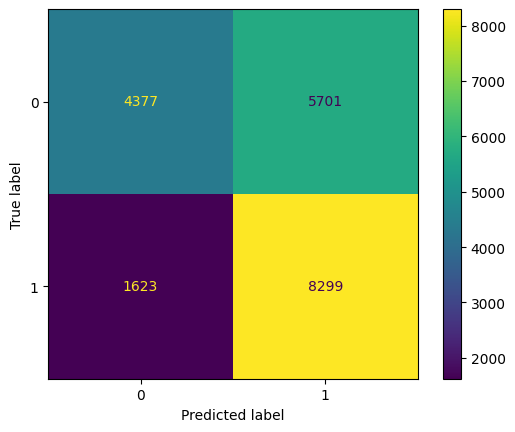

In [20]:
baseline_cm = metrics.confusion_matrix(y_true=valid[label], y_pred=1 - baseline_offer_valid)
btn, bfp, bfn, btp = baseline_cm.ravel()
metrics.ConfusionMatrixDisplay(confusion_matrix=baseline_cm).plot()

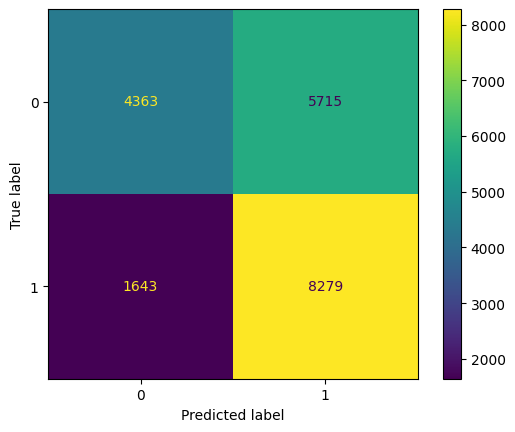

In [21]:
alternative_cm = metrics.confusion_matrix(y_true=valid[label], y_pred=1 - alternative_offer_valid)
atn, afp, afn, atp = alternative_cm.ravel()
metrics.ConfusionMatrixDisplay(confusion_matrix=alternative_cm).plot()

In [22]:
baseline_fp = bfp / (bfp + btn)
alternative_fp = afp / (afp + atn)

print(f"Baseline False Positive Rate:    {baseline_fp:0.2%}")
print(f"Alternative False Positive Rate: {alternative_fp:0.2%}")

Baseline False Positive Rate:    56.57%
Alternative False Positive Rate: 56.71%


In [23]:
fbtn, fbfp, fbfn, fbtp = metrics.confusion_matrix(y_true=valid.loc[valid['Female'] == 1, label], y_pred=1 - baseline_offer_valid.loc[valid['Female'] == 1]).ravel()
fatn, fafp, fafn, fatp = metrics.confusion_matrix(y_true=valid.loc[valid['Female'] == 1, label], y_pred=1 - alternative_offer_valid.loc[valid['Female'] == 1]).ravel()

baseline_female_fp = fbfp / (fbfp + fbtn)
alternative_female_fp = fafp / (fafp + fatn)

print(f"Baseline Female False Positive Rate:    {baseline_female_fp:0.2%}")
print(f"Alternative Female False Positive Rate: {alternative_female_fp:0.2%}")

Baseline Female False Positive Rate:    66.45%
Alternative Female False Positive Rate: 56.07%


In [24]:
mbtn, mbfp, mbfn, mbtp = metrics.confusion_matrix(y_true=valid.loc[valid['Female'] == 0, label], y_pred=1 - baseline_offer_valid.loc[valid['Female'] == 0]).ravel()
matn, mafp, mafn, matp = metrics.confusion_matrix(y_true=valid.loc[valid['Female'] == 0, label], y_pred=1 - alternative_offer_valid.loc[valid['Female'] == 0]).ravel()

baseline_male_fp = mbfp / (mbfp + mbtn)
alternative_male_fp = mafp / (mafp + matn)

print(f"Baseline Male False Positive Rate:    {baseline_male_fp:0.2%}")
print(f"Alternative Male False Positive Rate: {alternative_male_fp:0.2%}")

Baseline Male False Positive Rate:    47.91%
Alternative Male False Positive Rate: 57.27%
